In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

Global seed set to 0


In [2]:
adata = cr.datasets.pancreas()

In [3]:
scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.anvi_clean_recipe(adata, celltype_key='clusters')

Filtered out 22024 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# fit celltype annotated model

In [4]:
model = ltv.models.AnnotVAE(observed=2000, latent_dim=20, zr_dim=2, h_dim=2, 
                             celltypes=len(adata.obs.clusters.unique()))

In [5]:
epochs, val_ae, val_traj = ltv.train_anvi(model, adata, batch_size = 100,
                                      epochs=50, name='pancreas_annot_parameters')#, grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
910 velocity genes used


/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/dataloader.py:136: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


epoch 0, full loss 246.982, val loss 186.621, ae MSE 4.814, traj MSE 1.183, corr reg -2.342
epoch 1, full loss 169.673, val loss 96.828, ae MSE 3.714, traj MSE 1.076, corr reg -2.532
epoch 2, full loss 227.511, val loss 10.918, ae MSE 3.082, traj MSE 1.050, corr reg -2.683
epoch 3, full loss 256.641, val loss -59.162, ae MSE 3.038, traj MSE 0.882, corr reg -2.265
epoch 4, full loss 72.540, val loss -102.514, ae MSE 2.637, traj MSE 0.819, corr reg -2.109
epoch 5, full loss 103.129, val loss -136.181, ae MSE 2.336, traj MSE 0.806, corr reg -2.118
epoch 6, full loss 101.900, val loss -178.202, ae MSE 2.263, traj MSE 0.785, corr reg -2.255
epoch 7, full loss 123.444, val loss -219.943, ae MSE 2.270, traj MSE 0.750, corr reg -2.353
epoch 8, full loss 91.398, val loss -259.890, ae MSE 2.356, traj MSE 0.732, corr reg -2.378
epoch 9, full loss 21.929, val loss -291.545, ae MSE 2.192, traj MSE 0.766, corr reg -2.458
epoch 10, full loss 52.171, val loss -316.423, ae MSE 2.159, traj MSE 0.701, co

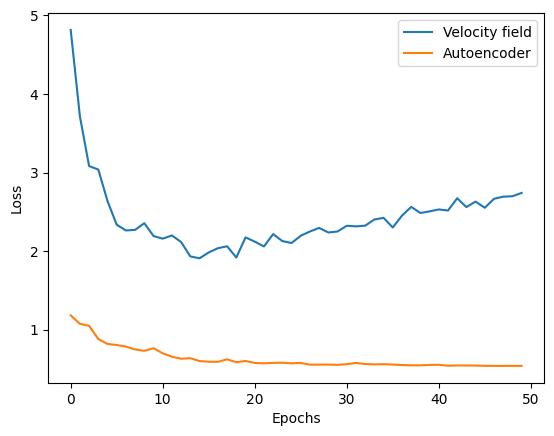

In [6]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

In [7]:
latent_adata = ltv.output_results(model, adata, annot=True)

In [8]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/spencer/.local/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


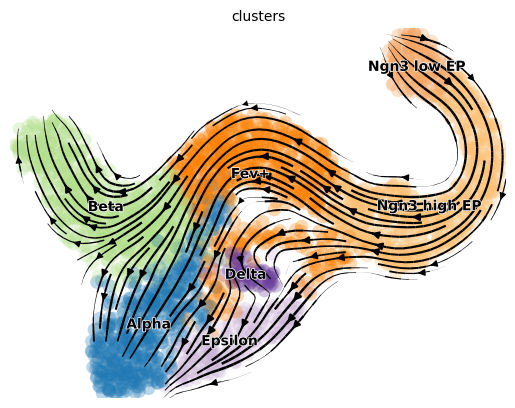

In [9]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity')

In [10]:
pancreas_edges = [
    ('Ngn3 low EP', 'Ngn3 high EP'), 
    ('Ngn3 high EP', 'Fev+'),
    ('Fev+', 'Delta'), 
    ('Fev+', 'Beta'), ('Fev+','Epsilon'), ('Fev+','Alpha')]

In [11]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
pancreas_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'clusters', 'spliced_velocity_pca', pancreas_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


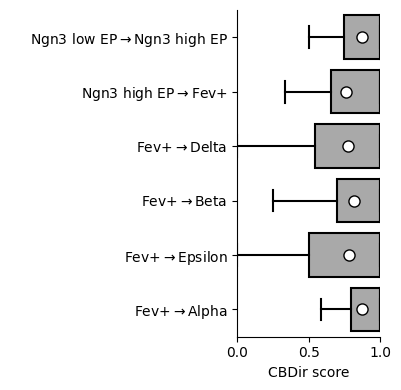

In [12]:
ax=ltv.pl.transition_scores(pancreas_pca, raw=True)
ax.set(xlim=(0,1))
plt.show()

# Plot UMAP in inferred latent space

In [13]:
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [14]:
scv.tl.umap(latent_adata)

computing velocity graph (using 1/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

/home/spencer/.local/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


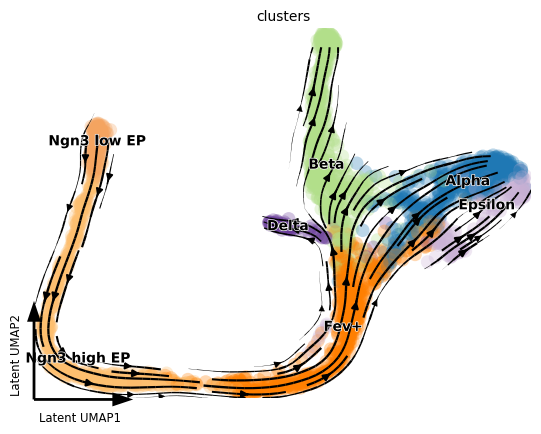

In [15]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', color='clusters', xlabel='Latent UMAP1',
                                ylabel='Latent UMAP2', frameon='artist')